[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomDefendCenter-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-27 09:18:22,912] Making new env: ppaquette/DoomDefendCenter-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

0.0 False


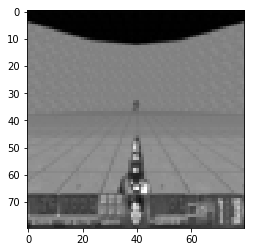

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
distilled_path = "distilled/default_amn.pcl"

In [10]:
from agentnet.utils.persistence import save,load
load(action_layer, distilled_path)

In [11]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [12]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [14]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-27 09:18:23,852] Making new env: ppaquette/DoomDefendCenter-v0


In [15]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[2 2 3 2 0 2 0]]
[[ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 83.1 ms


In [16]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [17]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [18]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [19]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [20]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-27 09:18:53,882] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:18:53,892] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-27 09:18:54,137] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.25338.video000000.mp4


Episode finished after 51 timesteps with reward=-1.0


[2017-06-27 09:18:55,374] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.25338.video000001.mp4


Episode finished after 46 timesteps with reward=-1.0
Episode finished after 52 timesteps with reward=-1.0
Episode finished after 60 timesteps with reward=-1.0
Episode finished after 70 timesteps with reward=-1.0
Episode finished after 65 timesteps with reward=-1.0
Episode finished after 64 timesteps with reward=0.0


[2017-06-27 09:19:01,302] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.25338.video000008.mp4


Episode finished after 47 timesteps with reward=-1.0
Episode finished after 45 timesteps with reward=-1.0


[2017-06-27 09:19:03,148] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 59 timesteps with reward=0.0


# Training loop

In [21]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [22]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000, 4000):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 11/2000 [00:02<07:31,  4.41it/s]

iter=10	epsilon=0.954	reward/step=0.01818


  1%|          | 21/2000 [00:04<07:24,  4.46it/s]

iter=20	epsilon=0.910	reward/step=0.00476


  2%|▏         | 31/2000 [00:07<07:26,  4.41it/s]

iter=30	epsilon=0.868	reward/step=-0.00323


  2%|▏         | 41/2000 [00:09<07:27,  4.38it/s]

iter=40	epsilon=0.828	reward/step=0.00488


  2%|▏         | 49/2000 [00:11<07:51,  4.14it/s][2017-06-27 09:19:14,933] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:19:14,940] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=0.00392
Episode finished after 70 timesteps with reward=0.0
Episode finished after 48 timesteps with reward=0.0
Episode finished after 85 timesteps with reward=2.0
Episode finished after 46 timesteps with reward=-1.0


[2017-06-27 09:19:19,173] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  2%|▎         | 50/2000 [00:15<49:47,  1.53s/it]

Episode finished after 50 timesteps with reward=1.0


  3%|▎         | 60/2000 [00:18<09:35,  3.37it/s]

iter=60	epsilon=0.754	reward/step=0.00164


  4%|▎         | 70/2000 [00:21<08:12,  3.92it/s]

iter=70	epsilon=0.719	reward/step=0.00423


  4%|▍         | 80/2000 [00:23<08:16,  3.87it/s]

iter=80	epsilon=0.687	reward/step=0.00741


  4%|▍         | 90/2000 [00:26<08:32,  3.73it/s]

iter=90	epsilon=0.656	reward/step=0.00659


  5%|▍         | 99/2000 [00:28<07:55,  4.00it/s][2017-06-27 09:19:31,778] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:19:31,783] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=0.00693
Episode finished after 73 timesteps with reward=1.0
Episode finished after 58 timesteps with reward=0.0
Episode finished after 91 timesteps with reward=5.0
Episode finished after 59 timesteps with reward=0.0


[2017-06-27 09:19:36,887] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 100/2000 [00:33<57:02,  1.80s/it]

Episode finished after 82 timesteps with reward=2.0


  6%|▌         | 110/2000 [00:36<09:48,  3.21it/s]

iter=110	epsilon=0.598	reward/step=0.00811


  6%|▌         | 120/2000 [00:38<08:32,  3.67it/s]

iter=120	epsilon=0.571	reward/step=0.00744


  6%|▋         | 130/2000 [00:41<08:33,  3.64it/s]

iter=130	epsilon=0.546	reward/step=0.00992


  7%|▋         | 140/2000 [00:44<08:43,  3.55it/s]

iter=140	epsilon=0.522	reward/step=0.00993


  7%|▋         | 149/2000 [00:46<08:20,  3.70it/s][2017-06-27 09:19:50,097] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:19:50,102] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=0.00861
Episode finished after 80 timesteps with reward=2.0
Episode finished after 75 timesteps with reward=1.0
Episode finished after 72 timesteps with reward=0.0
Episode finished after 59 timesteps with reward=0.0


[2017-06-27 09:19:55,006] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 150/2000 [00:51<54:22,  1.76s/it]

Episode finished after 63 timesteps with reward=1.0


  8%|▊         | 160/2000 [00:54<10:05,  3.04it/s]

iter=160	epsilon=0.477	reward/step=0.00932


  8%|▊         | 170/2000 [00:57<08:49,  3.46it/s]

iter=170	epsilon=0.456	reward/step=0.00877


  9%|▉         | 180/2000 [01:00<08:44,  3.47it/s]

iter=180	epsilon=0.436	reward/step=0.00939


 10%|▉         | 190/2000 [01:02<08:55,  3.38it/s]

iter=190	epsilon=0.417	reward/step=0.00890


 10%|▉         | 199/2000 [01:05<08:42,  3.45it/s][2017-06-27 09:20:09,056] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:20:09,061] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=0.00846
Episode finished after 46 timesteps with reward=1.0
Episode finished after 62 timesteps with reward=1.0
Episode finished after 56 timesteps with reward=-1.0
Episode finished after 46 timesteps with reward=0.0


[2017-06-27 09:20:13,090] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 200/2000 [01:09<45:28,  1.52s/it]

Episode finished after 72 timesteps with reward=2.0


 10%|█         | 210/2000 [01:12<10:11,  2.93it/s]

iter=210	epsilon=0.382	reward/step=0.00900


 11%|█         | 220/2000 [01:15<09:46,  3.04it/s]

iter=220	epsilon=0.366	reward/step=0.00860


 12%|█▏        | 230/2000 [01:19<09:54,  2.98it/s]

iter=230	epsilon=0.351	reward/step=0.00823


 12%|█▏        | 240/2000 [01:22<09:57,  2.95it/s]

iter=240	epsilon=0.336	reward/step=0.00788


 12%|█▏        | 249/2000 [01:25<09:39,  3.02it/s][2017-06-27 09:20:28,986] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:20:28,995] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=0.00797
Episode finished after 47 timesteps with reward=1.0
Episode finished after 83 timesteps with reward=4.0
Episode finished after 62 timesteps with reward=1.0
Episode finished after 82 timesteps with reward=1.0


[2017-06-27 09:20:33,647] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 12%|█▎        | 250/2000 [01:30<50:59,  1.75s/it]

Episode finished after 56 timesteps with reward=-1.0


 13%|█▎        | 260/2000 [01:33<11:12,  2.59it/s]

iter=260	epsilon=0.309	reward/step=0.00805


 14%|█▎        | 270/2000 [01:37<10:08,  2.85it/s]

iter=270	epsilon=0.296	reward/step=0.00812


 14%|█▍        | 280/2000 [01:40<10:10,  2.82it/s]

iter=280	epsilon=0.284	reward/step=0.00819


 14%|█▍        | 290/2000 [01:44<10:15,  2.78it/s]

iter=290	epsilon=0.273	reward/step=0.00893


 15%|█▍        | 299/2000 [01:47<09:52,  2.87it/s][2017-06-27 09:20:50,778] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:20:50,783] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=0.00900
Episode finished after 72 timesteps with reward=0.0
Episode finished after 73 timesteps with reward=0.0
Episode finished after 88 timesteps with reward=2.0
Episode finished after 62 timesteps with reward=1.0


[2017-06-27 09:20:56,249] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 300/2000 [01:53<56:53,  2.01s/it]

Episode finished after 91 timesteps with reward=3.0


 16%|█▌        | 310/2000 [01:56<11:25,  2.47it/s]

iter=310	epsilon=0.252	reward/step=0.00867


 16%|█▌        | 320/2000 [02:00<09:59,  2.80it/s]

iter=320	epsilon=0.242	reward/step=0.00900


 16%|█▋        | 330/2000 [02:03<09:55,  2.80it/s]

iter=330	epsilon=0.232	reward/step=0.01033


 17%|█▋        | 340/2000 [02:06<09:51,  2.81it/s]

iter=340	epsilon=0.224	reward/step=0.01000


 17%|█▋        | 349/2000 [02:09<09:29,  2.90it/s][2017-06-27 09:21:13,552] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:21:13,556] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=0.00967
Episode finished after 87 timesteps with reward=2.0
Episode finished after 85 timesteps with reward=2.0
Episode finished after 70 timesteps with reward=0.0
Episode finished after 72 timesteps with reward=0.0


[2017-06-27 09:21:19,338] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 350/2000 [02:16<57:36,  2.09s/it]

Episode finished after 105 timesteps with reward=3.0


 18%|█▊        | 360/2000 [02:19<10:59,  2.49it/s]

iter=360	epsilon=0.207	reward/step=0.01033


 18%|█▊        | 370/2000 [02:23<09:42,  2.80it/s]

iter=370	epsilon=0.199	reward/step=0.01000


 19%|█▉        | 380/2000 [02:26<09:33,  2.82it/s]

iter=380	epsilon=0.192	reward/step=0.01000


 20%|█▉        | 390/2000 [02:29<09:26,  2.84it/s]

iter=390	epsilon=0.185	reward/step=0.01067


 20%|█▉        | 399/2000 [02:32<09:05,  2.94it/s][2017-06-27 09:21:36,466] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:21:36,471] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=0.01100
Episode finished after 78 timesteps with reward=1.0
Episode finished after 41 timesteps with reward=0.0
Episode finished after 40 timesteps with reward=0.0
Episode finished after 66 timesteps with reward=1.0


[2017-06-27 09:21:40,536] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 400/2000 [02:37<42:09,  1.58s/it]

Episode finished after 58 timesteps with reward=1.0


 20%|██        | 410/2000 [02:40<10:21,  2.56it/s]

iter=410	epsilon=0.172	reward/step=0.01167


 21%|██        | 420/2000 [02:44<09:33,  2.75it/s]

iter=420	epsilon=0.166	reward/step=0.01267


 22%|██▏       | 430/2000 [02:47<09:18,  2.81it/s]

iter=430	epsilon=0.161	reward/step=0.01133


 22%|██▏       | 440/2000 [02:51<09:09,  2.84it/s]

iter=440	epsilon=0.155	reward/step=0.01100


 22%|██▏       | 449/2000 [02:54<08:49,  2.93it/s][2017-06-27 09:21:57,736] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:21:57,740] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=0.01200
Episode finished after 66 timesteps with reward=1.0
Episode finished after 63 timesteps with reward=2.0
Episode finished after 95 timesteps with reward=4.0
Episode finished after 68 timesteps with reward=3.0


[2017-06-27 09:22:02,440] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 22%|██▎       | 450/2000 [02:59<45:41,  1.77s/it]

Episode finished after 45 timesteps with reward=0.0


 23%|██▎       | 460/2000 [03:02<10:06,  2.54it/s]

iter=460	epsilon=0.145	reward/step=0.01267


 24%|██▎       | 470/2000 [03:06<09:05,  2.80it/s]

iter=470	epsilon=0.141	reward/step=0.01333


 24%|██▍       | 480/2000 [03:09<08:57,  2.83it/s]

iter=480	epsilon=0.136	reward/step=0.01333


 24%|██▍       | 490/2000 [03:12<08:57,  2.81it/s]

iter=490	epsilon=0.132	reward/step=0.01467


 25%|██▍       | 499/2000 [03:15<08:32,  2.93it/s][2017-06-27 09:22:19,583] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:22:19,587] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=0.01567
Episode finished after 55 timesteps with reward=0.0
Episode finished after 50 timesteps with reward=1.0
Episode finished after 44 timesteps with reward=0.0
Episode finished after 52 timesteps with reward=0.0


[2017-06-27 09:22:23,425] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 500/2000 [03:20<37:43,  1.51s/it]

Episode finished after 72 timesteps with reward=1.0


 26%|██▌       | 510/2000 [03:23<09:29,  2.62it/s]

iter=510	epsilon=0.124	reward/step=0.01467


 26%|██▌       | 520/2000 [03:27<08:52,  2.78it/s]

iter=520	epsilon=0.121	reward/step=0.01600


 26%|██▋       | 530/2000 [03:30<08:43,  2.81it/s]

iter=530	epsilon=0.117	reward/step=0.01667


 27%|██▋       | 540/2000 [03:33<08:41,  2.80it/s]

iter=540	epsilon=0.114	reward/step=0.01800


 27%|██▋       | 549/2000 [03:37<08:13,  2.94it/s][2017-06-27 09:22:40,594] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:22:40,599] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=0.01833
Episode finished after 138 timesteps with reward=7.0
Episode finished after 66 timesteps with reward=0.0
Episode finished after 81 timesteps with reward=1.0
Episode finished after 68 timesteps with reward=-1.0


[2017-06-27 09:22:46,415] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 550/2000 [03:43<50:53,  2.11s/it]

Episode finished after 64 timesteps with reward=0.0


 28%|██▊       | 560/2000 [03:46<09:41,  2.48it/s]

iter=560	epsilon=0.108	reward/step=0.01900


 28%|██▊       | 570/2000 [03:50<08:29,  2.81it/s]

iter=570	epsilon=0.105	reward/step=0.01967


 29%|██▉       | 580/2000 [03:53<08:18,  2.85it/s]

iter=580	epsilon=0.102	reward/step=0.01967


 30%|██▉       | 590/2000 [03:56<08:15,  2.84it/s]

iter=590	epsilon=0.100	reward/step=0.01967


 30%|██▉       | 599/2000 [03:59<08:01,  2.91it/s][2017-06-27 09:23:03,549] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:23:03,553] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=0.02067
Episode finished after 47 timesteps with reward=1.0
Episode finished after 96 timesteps with reward=5.0
Episode finished after 66 timesteps with reward=0.0
Episode finished after 109 timesteps with reward=5.0


[2017-06-27 09:23:09,094] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 600/2000 [04:05<47:06,  2.02s/it]

Episode finished after 81 timesteps with reward=1.0


 30%|███       | 610/2000 [04:09<09:17,  2.49it/s]

iter=610	epsilon=0.095	reward/step=0.02067


 31%|███       | 620/2000 [04:12<08:10,  2.81it/s]

iter=620	epsilon=0.093	reward/step=0.02167


 32%|███▏      | 630/2000 [04:16<08:12,  2.78it/s]

iter=630	epsilon=0.091	reward/step=0.02200


 32%|███▏      | 640/2000 [04:19<08:03,  2.81it/s]

iter=640	epsilon=0.089	reward/step=0.02267


 32%|███▏      | 649/2000 [04:22<07:41,  2.93it/s][2017-06-27 09:23:26,308] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:23:26,313] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=0.02433
Episode finished after 78 timesteps with reward=2.0
Episode finished after 65 timesteps with reward=2.0
Episode finished after 66 timesteps with reward=4.0
Episode finished after 122 timesteps with reward=7.0


[2017-06-27 09:23:31,818] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 32%|███▎      | 650/2000 [04:28<45:20,  2.02s/it]

Episode finished after 66 timesteps with reward=4.0


 33%|███▎      | 660/2000 [04:32<08:54,  2.51it/s]

iter=660	epsilon=0.085	reward/step=0.02500


 34%|███▎      | 670/2000 [04:35<07:50,  2.83it/s]

iter=670	epsilon=0.083	reward/step=0.02600


 34%|███▍      | 680/2000 [04:38<07:48,  2.82it/s]

iter=680	epsilon=0.082	reward/step=0.02567


 34%|███▍      | 690/2000 [04:42<07:42,  2.83it/s]

iter=690	epsilon=0.080	reward/step=0.02700


 35%|███▍      | 699/2000 [04:45<07:21,  2.95it/s][2017-06-27 09:23:48,943] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:23:48,948] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=0.02667
Episode finished after 84 timesteps with reward=4.0
Episode finished after 83 timesteps with reward=4.0
Episode finished after 112 timesteps with reward=6.0
Episode finished after 87 timesteps with reward=4.0


[2017-06-27 09:23:55,629] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 700/2000 [04:52<51:13,  2.36s/it]

Episode finished after 122 timesteps with reward=6.0


 36%|███▌      | 710/2000 [04:55<08:46,  2.45it/s]

iter=710	epsilon=0.077	reward/step=0.02700


 36%|███▌      | 720/2000 [04:59<07:36,  2.81it/s]

iter=720	epsilon=0.076	reward/step=0.02733


 36%|███▋      | 730/2000 [05:02<07:30,  2.82it/s]

iter=730	epsilon=0.075	reward/step=0.02933


 37%|███▋      | 740/2000 [05:06<07:31,  2.79it/s]

iter=740	epsilon=0.073	reward/step=0.03000


 37%|███▋      | 749/2000 [05:09<07:09,  2.92it/s][2017-06-27 09:24:12,823] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:24:12,828] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=0.03033
Episode finished after 119 timesteps with reward=6.0
Episode finished after 114 timesteps with reward=5.0
Episode finished after 86 timesteps with reward=3.0
Episode finished after 174 timesteps with reward=8.0


[2017-06-27 09:24:20,882] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 750/2000 [05:17<57:52,  2.78s/it]

Episode finished after 89 timesteps with reward=2.0


 38%|███▊      | 760/2000 [05:21<08:42,  2.37it/s]

iter=760	epsilon=0.071	reward/step=0.03100


 38%|███▊      | 770/2000 [05:24<07:16,  2.82it/s]

iter=770	epsilon=0.070	reward/step=0.03200


 39%|███▉      | 780/2000 [05:27<07:09,  2.84it/s]

iter=780	epsilon=0.069	reward/step=0.03300


 40%|███▉      | 790/2000 [05:31<07:06,  2.84it/s]

iter=790	epsilon=0.068	reward/step=0.03300


 40%|███▉      | 799/2000 [05:34<06:51,  2.92it/s][2017-06-27 09:24:37,969] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:24:37,974] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=0.03400
Episode finished after 173 timesteps with reward=9.0
Episode finished after 98 timesteps with reward=4.0
Episode finished after 88 timesteps with reward=5.0
Episode finished after 88 timesteps with reward=1.0


[2017-06-27 09:24:45,292] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 800/2000 [05:42<51:07,  2.56s/it]

Episode finished after 86 timesteps with reward=1.0


 40%|████      | 810/2000 [05:45<08:15,  2.40it/s]

iter=810	epsilon=0.067	reward/step=0.03567


 41%|████      | 820/2000 [05:48<07:00,  2.81it/s]

iter=820	epsilon=0.066	reward/step=0.03467


 42%|████▏     | 830/2000 [05:52<07:03,  2.76it/s]

iter=830	epsilon=0.065	reward/step=0.03500


 42%|████▏     | 840/2000 [05:55<06:52,  2.81it/s]

iter=840	epsilon=0.064	reward/step=0.03533


 42%|████▏     | 849/2000 [05:58<06:37,  2.90it/s][2017-06-27 09:25:02,494] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:25:02,499] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=0.03600
Episode finished after 82 timesteps with reward=2.0
Episode finished after 69 timesteps with reward=3.0
Episode finished after 51 timesteps with reward=0.0
Episode finished after 88 timesteps with reward=2.0


[2017-06-27 09:25:07,555] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 42%|████▎     | 850/2000 [06:04<35:59,  1.88s/it]

Episode finished after 74 timesteps with reward=1.0


 43%|████▎     | 860/2000 [06:07<07:33,  2.52it/s]

iter=860	epsilon=0.063	reward/step=0.03600


 44%|████▎     | 870/2000 [06:11<06:35,  2.86it/s]

iter=870	epsilon=0.062	reward/step=0.03667


 44%|████▍     | 880/2000 [06:14<06:34,  2.84it/s]

iter=880	epsilon=0.062	reward/step=0.03733


 44%|████▍     | 890/2000 [06:18<06:30,  2.84it/s]

iter=890	epsilon=0.061	reward/step=0.03733


 45%|████▍     | 899/2000 [06:21<06:14,  2.94it/s][2017-06-27 09:25:24,633] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:25:24,639] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=0.03700
Episode finished after 98 timesteps with reward=2.0
Episode finished after 94 timesteps with reward=3.0
Episode finished after 119 timesteps with reward=6.0
Episode finished after 107 timesteps with reward=4.0


[2017-06-27 09:25:31,879] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 900/2000 [06:28<46:23,  2.53s/it]

Episode finished after 113 timesteps with reward=6.0


 46%|████▌     | 910/2000 [06:32<07:31,  2.41it/s]

iter=910	epsilon=0.060	reward/step=0.03833


 46%|████▌     | 920/2000 [06:35<06:22,  2.82it/s]

iter=920	epsilon=0.060	reward/step=0.03833


 46%|████▋     | 930/2000 [06:38<06:20,  2.82it/s]

iter=930	epsilon=0.059	reward/step=0.03867


 47%|████▋     | 940/2000 [06:42<06:12,  2.84it/s]

iter=940	epsilon=0.059	reward/step=0.03900


 47%|████▋     | 949/2000 [06:45<05:57,  2.94it/s][2017-06-27 09:25:48,985] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:25:48,990] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=0.03833
Episode finished after 154 timesteps with reward=9.0
Episode finished after 94 timesteps with reward=4.0
Episode finished after 122 timesteps with reward=6.0
Episode finished after 119 timesteps with reward=7.0


[2017-06-27 09:25:56,705] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 950/2000 [06:53<46:46,  2.67s/it]

Episode finished after 78 timesteps with reward=2.0


 48%|████▊     | 960/2000 [06:56<07:15,  2.39it/s]

iter=960	epsilon=0.058	reward/step=0.03867


 48%|████▊     | 970/2000 [07:00<06:08,  2.79it/s]

iter=970	epsilon=0.057	reward/step=0.03967


 49%|████▉     | 980/2000 [07:03<06:01,  2.82it/s]

iter=980	epsilon=0.057	reward/step=0.04033


 50%|████▉     | 990/2000 [07:07<05:59,  2.81it/s]

iter=990	epsilon=0.057	reward/step=0.04000


 50%|████▉     | 999/2000 [07:10<05:43,  2.91it/s][2017-06-27 09:26:13,897] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:26:13,902] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=0.04033
Episode finished after 155 timesteps with reward=10.0
Episode finished after 74 timesteps with reward=2.0
Episode finished after 148 timesteps with reward=6.0
Episode finished after 88 timesteps with reward=3.0


[2017-06-27 09:26:21,530] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1000/2000 [07:18<44:09,  2.65s/it]

Episode finished after 96 timesteps with reward=2.0


 50%|█████     | 1010/2000 [07:21<06:56,  2.38it/s]

iter=1010	epsilon=0.056	reward/step=0.04067


 51%|█████     | 1020/2000 [07:25<05:51,  2.78it/s]

iter=1020	epsilon=0.056	reward/step=0.04000


 52%|█████▏    | 1030/2000 [07:28<05:45,  2.81it/s]

iter=1030	epsilon=0.056	reward/step=0.04000


 52%|█████▏    | 1040/2000 [07:32<05:41,  2.81it/s]

iter=1040	epsilon=0.055	reward/step=0.04100


 52%|█████▏    | 1049/2000 [07:35<05:26,  2.91it/s][2017-06-27 09:26:38,768] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:26:38,772] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=0.04067
Episode finished after 64 timesteps with reward=2.0
Episode finished after 150 timesteps with reward=7.0
Episode finished after 138 timesteps with reward=7.0
Episode finished after 78 timesteps with reward=2.0


[2017-06-27 09:26:45,896] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 52%|█████▎    | 1050/2000 [07:42<39:34,  2.50s/it]

Episode finished after 88 timesteps with reward=5.0


 53%|█████▎    | 1060/2000 [07:46<06:30,  2.41it/s]

iter=1060	epsilon=0.055	reward/step=0.04033


 54%|█████▎    | 1070/2000 [07:49<05:32,  2.80it/s]

iter=1070	epsilon=0.055	reward/step=0.04067


 54%|█████▍    | 1080/2000 [07:53<05:25,  2.83it/s]

iter=1080	epsilon=0.054	reward/step=0.04100


 55%|█████▍    | 1090/2000 [07:56<05:21,  2.83it/s]

iter=1090	epsilon=0.054	reward/step=0.04100


 55%|█████▍    | 1099/2000 [07:59<05:07,  2.93it/s][2017-06-27 09:27:03,077] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:27:03,082] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=0.04133
Episode finished after 126 timesteps with reward=5.0
Episode finished after 121 timesteps with reward=6.0
Episode finished after 128 timesteps with reward=7.0
Episode finished after 149 timesteps with reward=10.0


[2017-06-27 09:27:11,451] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1100/2000 [08:08<43:03,  2.87s/it]

Episode finished after 89 timesteps with reward=4.0


 56%|█████▌    | 1110/2000 [08:11<06:31,  2.27it/s]

iter=1110	epsilon=0.054	reward/step=0.04167


 56%|█████▌    | 1120/2000 [08:15<05:12,  2.81it/s]

iter=1120	epsilon=0.054	reward/step=0.04300


 56%|█████▋    | 1130/2000 [08:18<05:08,  2.82it/s]

iter=1130	epsilon=0.053	reward/step=0.04367


 57%|█████▋    | 1140/2000 [08:22<05:04,  2.82it/s]

iter=1140	epsilon=0.053	reward/step=0.04300


 57%|█████▋    | 1149/2000 [08:25<04:51,  2.92it/s][2017-06-27 09:27:28,829] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:27:28,833] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=0.04333
Episode finished after 90 timesteps with reward=5.0
Episode finished after 113 timesteps with reward=6.0
Episode finished after 81 timesteps with reward=5.0
Episode finished after 82 timesteps with reward=2.0


[2017-06-27 09:27:34,793] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 57%|█████▊    | 1150/2000 [08:31<30:29,  2.15s/it]

Episode finished after 67 timesteps with reward=2.0


 58%|█████▊    | 1160/2000 [08:35<05:38,  2.48it/s]

iter=1160	epsilon=0.053	reward/step=0.04333


 58%|█████▊    | 1170/2000 [08:38<04:54,  2.82it/s]

iter=1170	epsilon=0.053	reward/step=0.04333


 59%|█████▉    | 1180/2000 [08:41<04:50,  2.82it/s]

iter=1180	epsilon=0.053	reward/step=0.04367


 60%|█████▉    | 1190/2000 [08:45<04:46,  2.82it/s]

iter=1190	epsilon=0.052	reward/step=0.04433


 60%|█████▉    | 1199/2000 [08:48<04:34,  2.92it/s][2017-06-27 09:27:51,930] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:27:51,935] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=0.04400
Episode finished after 89 timesteps with reward=3.0
Episode finished after 99 timesteps with reward=4.0
Episode finished after 90 timesteps with reward=2.0
Episode finished after 97 timesteps with reward=3.0


[2017-06-27 09:27:58,036] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1200/2000 [08:54<29:14,  2.19s/it]

Episode finished after 68 timesteps with reward=3.0


 60%|██████    | 1210/2000 [08:58<05:19,  2.47it/s]

iter=1210	epsilon=0.052	reward/step=0.04400


 61%|██████    | 1220/2000 [09:01<04:42,  2.76it/s]

iter=1220	epsilon=0.052	reward/step=0.04500


 62%|██████▏   | 1230/2000 [09:05<04:32,  2.83it/s]

iter=1230	epsilon=0.052	reward/step=0.04567


 62%|██████▏   | 1240/2000 [09:08<04:28,  2.83it/s]

iter=1240	epsilon=0.052	reward/step=0.04433


 62%|██████▏   | 1249/2000 [09:11<04:17,  2.92it/s][2017-06-27 09:28:15,167] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:28:15,171] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=0.04533
Episode finished after 108 timesteps with reward=4.0
Episode finished after 48 timesteps with reward=0.0
Episode finished after 62 timesteps with reward=1.0
Episode finished after 91 timesteps with reward=2.0


[2017-06-27 09:28:20,471] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 62%|██████▎   | 1250/2000 [09:17<24:21,  1.95s/it]

Episode finished after 76 timesteps with reward=1.0


 63%|██████▎   | 1260/2000 [09:20<04:54,  2.51it/s]

iter=1260	epsilon=0.052	reward/step=0.04467


 64%|██████▎   | 1270/2000 [09:24<04:18,  2.82it/s]

iter=1270	epsilon=0.052	reward/step=0.04300


 64%|██████▍   | 1280/2000 [09:27<04:13,  2.84it/s]

iter=1280	epsilon=0.052	reward/step=0.04233


 64%|██████▍   | 1290/2000 [09:30<04:11,  2.82it/s]

iter=1290	epsilon=0.052	reward/step=0.04233


 65%|██████▍   | 1299/2000 [09:33<03:57,  2.96it/s][2017-06-27 09:28:37,575] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:28:37,580] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=0.04233
Episode finished after 74 timesteps with reward=2.0
Episode finished after 117 timesteps with reward=5.0
Episode finished after 76 timesteps with reward=3.0
Episode finished after 89 timesteps with reward=4.0


[2017-06-27 09:28:44,212] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1300/2000 [09:41<27:24,  2.35s/it]

Episode finished after 128 timesteps with reward=6.0


 66%|██████▌   | 1310/2000 [09:44<04:43,  2.44it/s]

iter=1310	epsilon=0.051	reward/step=0.04133


 66%|██████▌   | 1320/2000 [09:47<04:02,  2.81it/s]

iter=1320	epsilon=0.051	reward/step=0.04233


 66%|██████▋   | 1330/2000 [09:51<03:59,  2.80it/s]

iter=1330	epsilon=0.051	reward/step=0.04200


 67%|██████▋   | 1340/2000 [09:54<03:53,  2.82it/s]

iter=1340	epsilon=0.051	reward/step=0.04267


 67%|██████▋   | 1349/2000 [09:57<03:43,  2.91it/s][2017-06-27 09:29:01,407] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:29:01,411] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=0.04333
Episode finished after 172 timesteps with reward=10.0
Episode finished after 133 timesteps with reward=6.0
Episode finished after 226 timesteps with reward=17.0
Episode finished after 95 timesteps with reward=4.0


[2017-06-27 09:29:11,349] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1350/2000 [10:08<36:11,  3.34s/it]

Episode finished after 109 timesteps with reward=4.0


 68%|██████▊   | 1360/2000 [10:11<04:41,  2.27it/s]

iter=1360	epsilon=0.051	reward/step=0.04433


 68%|██████▊   | 1370/2000 [10:15<03:43,  2.82it/s]

iter=1370	epsilon=0.051	reward/step=0.04333


 69%|██████▉   | 1380/2000 [10:18<03:38,  2.83it/s]

iter=1380	epsilon=0.051	reward/step=0.04233


 70%|██████▉   | 1390/2000 [10:21<03:35,  2.84it/s]

iter=1390	epsilon=0.051	reward/step=0.04167


 70%|██████▉   | 1399/2000 [10:24<03:27,  2.90it/s][2017-06-27 09:29:28,505] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:29:28,510] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=0.04067
Episode finished after 86 timesteps with reward=2.0
Episode finished after 161 timesteps with reward=10.0
Episode finished after 62 timesteps with reward=1.0
Episode finished after 52 timesteps with reward=1.0


[2017-06-27 09:29:34,117] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1400/2000 [10:30<20:23,  2.04s/it]

Episode finished after 44 timesteps with reward=-1.0


 70%|███████   | 1410/2000 [10:34<03:56,  2.50it/s]

iter=1410	epsilon=0.051	reward/step=0.04000


 71%|███████   | 1420/2000 [10:37<03:29,  2.77it/s]

iter=1420	epsilon=0.051	reward/step=0.04000


 72%|███████▏  | 1430/2000 [10:41<03:21,  2.83it/s]

iter=1430	epsilon=0.051	reward/step=0.03933


 72%|███████▏  | 1440/2000 [10:44<03:16,  2.85it/s]

iter=1440	epsilon=0.051	reward/step=0.04000


 72%|███████▏  | 1449/2000 [10:47<03:07,  2.94it/s][2017-06-27 09:29:51,266] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:29:51,270] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=0.04033
Episode finished after 73 timesteps with reward=1.0
Episode finished after 105 timesteps with reward=4.0
Episode finished after 104 timesteps with reward=5.0
Episode finished after 84 timesteps with reward=4.0


[2017-06-27 09:29:57,842] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 72%|███████▎  | 1450/2000 [10:54<21:21,  2.33s/it]

Episode finished after 113 timesteps with reward=5.0


 73%|███████▎  | 1460/2000 [10:58<03:40,  2.45it/s]

iter=1460	epsilon=0.051	reward/step=0.04167


 74%|███████▎  | 1470/2000 [11:01<03:07,  2.82it/s]

iter=1470	epsilon=0.051	reward/step=0.04100


 74%|███████▍  | 1480/2000 [11:04<03:03,  2.84it/s]

iter=1480	epsilon=0.051	reward/step=0.04100


 74%|███████▍  | 1490/2000 [11:08<02:59,  2.84it/s]

iter=1490	epsilon=0.051	reward/step=0.04133


 75%|███████▍  | 1499/2000 [11:11<02:50,  2.94it/s][2017-06-27 09:30:14,890] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:30:14,895] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=0.04100
Episode finished after 102 timesteps with reward=5.0
Episode finished after 102 timesteps with reward=4.0
Episode finished after 95 timesteps with reward=4.0
Episode finished after 165 timesteps with reward=11.0


[2017-06-27 09:30:22,588] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1500/2000 [11:19<22:12,  2.67s/it]

Episode finished after 102 timesteps with reward=5.0


 76%|███████▌  | 1510/2000 [11:22<03:25,  2.39it/s]

iter=1510	epsilon=0.050	reward/step=0.04133


 76%|███████▌  | 1520/2000 [11:26<02:52,  2.78it/s]

iter=1520	epsilon=0.050	reward/step=0.04133


 76%|███████▋  | 1530/2000 [11:29<02:45,  2.83it/s]

iter=1530	epsilon=0.050	reward/step=0.03967


 77%|███████▋  | 1540/2000 [11:33<02:41,  2.84it/s]

iter=1540	epsilon=0.050	reward/step=0.04133


 77%|███████▋  | 1549/2000 [11:36<02:32,  2.95it/s][2017-06-27 09:30:39,691] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:30:39,696] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=0.04033
Episode finished after 148 timesteps with reward=7.0
Episode finished after 93 timesteps with reward=4.0
Episode finished after 90 timesteps with reward=3.0
Episode finished after 166 timesteps with reward=9.0


[2017-06-27 09:30:47,202] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1550/2000 [11:44<19:34,  2.61s/it]

Episode finished after 55 timesteps with reward=3.0


 78%|███████▊  | 1560/2000 [11:47<03:03,  2.40it/s]

iter=1560	epsilon=0.050	reward/step=0.04233


 78%|███████▊  | 1570/2000 [11:50<02:33,  2.81it/s]

iter=1570	epsilon=0.050	reward/step=0.04233


 79%|███████▉  | 1580/2000 [11:54<02:28,  2.84it/s]

iter=1580	epsilon=0.050	reward/step=0.04300


 80%|███████▉  | 1590/2000 [11:57<02:24,  2.83it/s]

iter=1590	epsilon=0.050	reward/step=0.04300


 80%|███████▉  | 1599/2000 [12:00<02:16,  2.93it/s][2017-06-27 09:31:04,287] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:31:04,292] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=0.04467
Episode finished after 125 timesteps with reward=9.0
Episode finished after 139 timesteps with reward=7.0
Episode finished after 151 timesteps with reward=8.0
Episode finished after 106 timesteps with reward=5.0


[2017-06-27 09:31:13,370] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1600/2000 [12:10<20:32,  3.08s/it]

Episode finished after 149 timesteps with reward=10.0


 80%|████████  | 1610/2000 [12:13<02:47,  2.33it/s]

iter=1610	epsilon=0.050	reward/step=0.04467


 81%|████████  | 1620/2000 [12:17<02:16,  2.79it/s]

iter=1620	epsilon=0.050	reward/step=0.04500


 82%|████████▏ | 1630/2000 [12:20<02:12,  2.80it/s]

iter=1630	epsilon=0.050	reward/step=0.04533


 82%|████████▏ | 1640/2000 [12:23<02:07,  2.82it/s]

iter=1640	epsilon=0.050	reward/step=0.04467


 82%|████████▏ | 1649/2000 [12:26<02:00,  2.91it/s][2017-06-27 09:31:30,574] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:31:30,578] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=0.04600
Episode finished after 58 timesteps with reward=2.0
Episode finished after 64 timesteps with reward=1.0
Episode finished after 104 timesteps with reward=5.0
Episode finished after 105 timesteps with reward=6.0


[2017-06-27 09:31:37,147] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 82%|████████▎ | 1650/2000 [12:33<13:35,  2.33s/it]

Episode finished after 146 timesteps with reward=7.0


 83%|████████▎ | 1660/2000 [12:37<02:19,  2.44it/s]

iter=1660	epsilon=0.050	reward/step=0.04467


 84%|████████▎ | 1670/2000 [12:40<01:57,  2.80it/s]

iter=1670	epsilon=0.050	reward/step=0.04567


 84%|████████▍ | 1680/2000 [12:44<01:54,  2.80it/s]

iter=1680	epsilon=0.050	reward/step=0.04600


 84%|████████▍ | 1690/2000 [12:47<01:49,  2.84it/s]

iter=1690	epsilon=0.050	reward/step=0.04600


 85%|████████▍ | 1699/2000 [12:50<01:43,  2.90it/s][2017-06-27 09:31:54,335] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:31:54,339] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=0.04633
Episode finished after 102 timesteps with reward=5.0
Episode finished after 60 timesteps with reward=1.0
Episode finished after 114 timesteps with reward=6.0
Episode finished after 133 timesteps with reward=7.0


[2017-06-27 09:32:01,111] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1700/2000 [12:57<11:58,  2.39s/it]

Episode finished after 85 timesteps with reward=3.0


 86%|████████▌ | 1710/2000 [13:01<01:59,  2.42it/s]

iter=1710	epsilon=0.050	reward/step=0.04667


 86%|████████▌ | 1720/2000 [13:04<01:40,  2.79it/s]

iter=1720	epsilon=0.050	reward/step=0.04600


 86%|████████▋ | 1730/2000 [13:08<01:35,  2.82it/s]

iter=1730	epsilon=0.050	reward/step=0.04667


 87%|████████▋ | 1740/2000 [13:11<01:32,  2.81it/s]

iter=1740	epsilon=0.050	reward/step=0.04800


 87%|████████▋ | 1749/2000 [13:14<01:26,  2.91it/s][2017-06-27 09:32:18,355] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:32:18,360] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=0.04733
Episode finished after 82 timesteps with reward=4.0
Episode finished after 97 timesteps with reward=5.0
Episode finished after 183 timesteps with reward=13.0
Episode finished after 112 timesteps with reward=6.0


[2017-06-27 09:32:26,611] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1750/2000 [13:23<11:49,  2.84s/it]

Episode finished after 129 timesteps with reward=7.0


 88%|████████▊ | 1760/2000 [13:26<01:41,  2.37it/s]

iter=1760	epsilon=0.050	reward/step=0.04667


 88%|████████▊ | 1770/2000 [13:30<01:21,  2.82it/s]

iter=1770	epsilon=0.050	reward/step=0.04867


 89%|████████▉ | 1780/2000 [13:33<01:17,  2.84it/s]

iter=1780	epsilon=0.050	reward/step=0.04800


 90%|████████▉ | 1790/2000 [13:37<01:14,  2.82it/s]

iter=1790	epsilon=0.050	reward/step=0.04833


 90%|████████▉ | 1799/2000 [13:40<01:08,  2.92it/s][2017-06-27 09:32:43,711] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:32:43,716] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=0.04967
Episode finished after 170 timesteps with reward=11.0
Episode finished after 122 timesteps with reward=8.0
Episode finished after 104 timesteps with reward=5.0
Episode finished after 92 timesteps with reward=4.0


[2017-06-27 09:32:51,354] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1800/2000 [13:48<08:50,  2.65s/it]

Episode finished after 72 timesteps with reward=3.0


 90%|█████████ | 1810/2000 [13:51<01:19,  2.38it/s]

iter=1810	epsilon=0.050	reward/step=0.04833


 91%|█████████ | 1820/2000 [13:55<01:04,  2.81it/s]

iter=1820	epsilon=0.050	reward/step=0.04700


 92%|█████████▏| 1830/2000 [13:58<01:00,  2.81it/s]

iter=1830	epsilon=0.050	reward/step=0.04933


 92%|█████████▏| 1840/2000 [14:01<00:56,  2.81it/s]

iter=1840	epsilon=0.050	reward/step=0.04867


 92%|█████████▏| 1849/2000 [14:05<00:51,  2.91it/s][2017-06-27 09:33:08,606] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:33:08,610] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=0.04967
Episode finished after 120 timesteps with reward=5.0
Episode finished after 70 timesteps with reward=3.0
Episode finished after 106 timesteps with reward=7.0
Episode finished after 92 timesteps with reward=5.0


[2017-06-27 09:33:16,315] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 92%|█████████▎| 1850/2000 [14:13<06:40,  2.67s/it]

Episode finished after 176 timesteps with reward=12.0


 93%|█████████▎| 1860/2000 [14:16<00:58,  2.38it/s]

iter=1860	epsilon=0.050	reward/step=0.04733


 94%|█████████▎| 1870/2000 [14:19<00:46,  2.78it/s]

iter=1870	epsilon=0.050	reward/step=0.04867


 94%|█████████▍| 1880/2000 [14:23<00:42,  2.81it/s]

iter=1880	epsilon=0.050	reward/step=0.04967


 94%|█████████▍| 1890/2000 [14:26<00:38,  2.84it/s]

iter=1890	epsilon=0.050	reward/step=0.04967


 95%|█████████▍| 1899/2000 [14:29<00:34,  2.92it/s][2017-06-27 09:33:33,482] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:33:33,486] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=0.04833
Episode finished after 89 timesteps with reward=8.0
Episode finished after 138 timesteps with reward=7.0
Episode finished after 188 timesteps with reward=11.0
Episode finished after 140 timesteps with reward=7.0


[2017-06-27 09:33:42,531] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1900/2000 [14:39<05:06,  3.07s/it]

Episode finished after 107 timesteps with reward=7.0


 96%|█████████▌| 1910/2000 [14:42<00:39,  2.27it/s]

iter=1910	epsilon=0.050	reward/step=0.04967


 96%|█████████▌| 1920/2000 [14:46<00:28,  2.81it/s]

iter=1920	epsilon=0.050	reward/step=0.04967


 96%|█████████▋| 1930/2000 [14:49<00:24,  2.84it/s]

iter=1930	epsilon=0.050	reward/step=0.04900


 97%|█████████▋| 1940/2000 [14:53<00:21,  2.82it/s]

iter=1940	epsilon=0.050	reward/step=0.04867


 97%|█████████▋| 1949/2000 [14:56<00:17,  2.92it/s][2017-06-27 09:33:59,873] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:33:59,877] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=0.04833
Episode finished after 116 timesteps with reward=6.0
Episode finished after 109 timesteps with reward=5.0
Episode finished after 98 timesteps with reward=3.0
Episode finished after 136 timesteps with reward=9.0


[2017-06-27 09:34:07,797] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1950/2000 [15:04<02:16,  2.74s/it]

Episode finished after 121 timesteps with reward=6.0


 98%|█████████▊| 1960/2000 [15:08<00:16,  2.38it/s]

iter=1960	epsilon=0.050	reward/step=0.04800


 98%|█████████▊| 1970/2000 [15:11<00:10,  2.83it/s]

iter=1970	epsilon=0.050	reward/step=0.04800


 99%|█████████▉| 1980/2000 [15:14<00:06,  2.86it/s]

iter=1980	epsilon=0.050	reward/step=0.04833


100%|█████████▉| 1990/2000 [15:18<00:03,  2.83it/s]

iter=1990	epsilon=0.050	reward/step=0.04967


100%|█████████▉| 1999/2000 [15:21<00:00,  2.87it/s][2017-06-27 09:34:24,920] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-27 09:34:24,925] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=0.05000
Episode finished after 170 timesteps with reward=11.0
Episode finished after 91 timesteps with reward=4.0
Episode finished after 213 timesteps with reward=12.0
Episode finished after 230 timesteps with reward=13.0


[2017-06-27 09:34:36,209] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [15:33<00:00,  3.75s/it]

Episode finished after 125 timesteps with reward=7.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

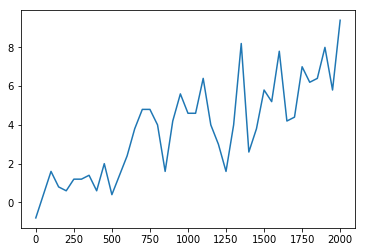

In [23]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [24]:
assert False

AssertionError: 

In [25]:
import os
#tmp = GAME_NAME.split('/')[1]
#os.mkdir(tmp)
with open('final/default_amn', 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], np.mean(rw[idx]), file=outp)

In [ ]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/{}.pcl".format(tmp, tmp))

## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets